# Self-RAG Example for extracting expected queries from document

In [19]:
docs_path = "/mnt/d/temp/user/ed/mart/mmplastic/20240725_154000_000000/data.json"

expected_query_vector_index_dirpath = "/mnt/d/temp/user/ed/warehouse/mmplastic/vector_index/selfrag_expected_query_vectors.faiss/20240807_150000_000000"

num_valid_queries = 3

In [20]:
embedding_model_name = "gemma-2-embed"
lang_model_name = "tiger-gemma2"

update_vector_index = {
    "chunk": False, 
    "expected_query": False, 
    "intent_summary": False, 
}

max_tokens = 1024

In [21]:
import re

from IPython.display import Image, display
from pprint import pprint
from pydantic import BaseModel
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableBranch, RunnableLambda, RunnableParallel, RunnablePassthrough

from langchain_ollama import ChatOllama

from langgraph.graph import START, END, StateGraph


In [22]:
expected_query_vector_db: Optional[FAISS] = None

## Model Declaration

In [23]:
embeddings = OllamaEmbeddings(
    model=embedding_model_name
)
llm = ChatOllama(
    model=lang_model_name,
    temperature=0.8,
    num_predict=max_tokens,
    num_gpu=-1
)

In [24]:
def remove_list_prefixes(input_string):
    lines = input_string.split('\n')
    cleaned_lines = []
    
    for line in lines:
        # Remove leading hyphens or numbered prefixes
        cleaned_line = re.sub(r'^\s*[-\d#]+\.\s*', '', line)
        cleaned_lines.append(cleaned_line)
    
    return '\n'.join(cleaned_lines)

### Expected Query Chain

In [25]:
parser = JsonOutputParser()


class ExpectedQuerySet(BaseModel):
    queries: List[str]


expected_queries_prompt = PromptTemplate.from_template(
    """
    아래 문장에서 만들 수 있는 핵심질문 {num_q}가지 만들어줘.
    예 또는 아니오로 대답하는 단답형 질문이 아니라, 텍스트 안의 사실이나 사건의 구체적 내용을 대답할 수 있는 질문을 만들어야 해.
    문장 마침표를 제외한 특수기호는 모두 제거해줘.
    {document}
    """
)
# expected_queries_prompt = JsonOutputParser(pydantic_object=ExpectedQuerySet)

In [26]:
def estimate_num_queries(x):
    return {"num_q": int(len(x["document"]) / 20), "document": x["document"]}

def fetch_expected_queries(text):
    maybe_queries = remove_list_prefixes(text)
    queries = list(filter(lambda d: d, maybe_queries.split("\n")))
    # queries = list(filter(lambda d: d, maybe_queries))
    return {"expected_queries": queries}

expected_query_chain = (
    {"document": RunnablePassthrough()} |
    RunnableLambda(estimate_num_queries) | 
    {"document": lambda x: x["document"], "num_q": lambda x: x["num_q"]} | expected_queries_prompt | llm | StrOutputParser() |
    RunnableLambda(fetch_expected_queries) |
    RunnablePassthrough.assign(expected_queries=lambda x: x["expected_queries"])
)

In [27]:
document = """30일 학계에 따르면 아미트 아브라함 카타르 웨일코넬의대 교수 연구팀은 국제학술지 '영국의학회지(BMJ) 세계 보건' 최신호에 발표한 논평을 통해 "인간과 지구의 건강을 위해 생수의 사용을 재고해야 한다"는 주장을 제기했다."""
pprint(document)

("30일 학계에 따르면 아미트 아브라함 카타르 웨일코넬의대 교수 연구팀은 국제학술지 '영국의학회지(BMJ) 세계 보건' 최신호에 발표한 "
 '논평을 통해 "인간과 지구의 건강을 위해 생수의 사용을 재고해야 한다"는 주장을 제기했다.')


In [28]:
expected_queries = expected_query_chain.invoke(document)
pprint(expected_queries)

{'expected_queries': ['아미트 아브라함 카타르 웨일코넬의대 교수가 어떤 국제학술지에 논평을 발표했나요?',
                      '해당 논평에서 연구팀은 인간과 지구의 건강에 대해 어떤 주장을 제기했나요?',
                      '연구팀이 이러한 주장을 뒷받침하는 근거는 무엇인가요?',
                      '왜 생수 사용을 재고해야 하는지 구체적인 이유를 설명해줘요.',
                      '해당 논평은 어떤 대중에게 영향을 미칠 수 있을까요?',
                      '연구팀이 제기한 주장에 대한 다른 사람들의 반응은 어떠했나요?']}


In [29]:
hallucination_check_prompt = PromptTemplate.from_template(
    """
    질문이 주어진 문서에서 다루는 사실에 근거한 내용을 포함한지 판단해줘
    문서: {context}
    질문: {question}

    설명없이 '예' 또는 '아니오'로 대답해줘
    """
)

In [30]:
hallucination_check_chain = hallucination_check_prompt | llm | StrOutputParser()

In [31]:
question = "인간과 지구의 건강에 미치는 영향에 대해 논평에서는 무엇을 제안했나요?"

decisions = []

for q in expected_queries["expected_queries"]:
    output = hallucination_check_chain.invoke(
        {
            "context": document,
            "question": q
        }
    )
    binary_decision = True if output.strip() in ['yes', '예'] else False
    decisions.append(binary_decision)

pprint(list(zip(expected_queries["expected_queries"], decisions)))

[('아미트 아브라함 카타르 웨일코넬의대 교수가 어떤 국제학술지에 논평을 발표했나요?', True),
 ('해당 논평에서 연구팀은 인간과 지구의 건강에 대해 어떤 주장을 제기했나요?', False),
 ('연구팀이 이러한 주장을 뒷받침하는 근거는 무엇인가요?', True),
 ('왜 생수 사용을 재고해야 하는지 구체적인 이유를 설명해줘요.', True),
 ('해당 논평은 어떤 대중에게 영향을 미칠 수 있을까요?', False),
 ('연구팀이 제기한 주장에 대한 다른 사람들의 반응은 어떠했나요?', False)]


## Build Graph Elements

### state

In [32]:
class State(TypedDict):
    """
    represents the state of graph
    """
    document: str
    queries: List[str]
    retry_fetch: str

### nodes

In [46]:
def fetch_queries(state):
    """
    extract and fetch expected queries from document

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    document = state["document"]

    queries = expected_query_chain.invoke(document)

    return {
        "queries": queries["expected_queries"] if queries else [],
        "document": document
    }


def filter_queries(state):
    """
    Determines whether the fetched queries are relevant to the document.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates queries key with only filtered relevant queries 
    """
    filtered_queries = []
    queries = state["queries"]
    document = state["document"]

    for q in queries:
        output = hallucination_check_chain.invoke(
            {
                "context": document,
                "question": q
            }
        )
        decision: str = output.strip()
        if decision in ["yes", "예"]:
            filtered_queries.append(q)
    return {
        "queries": filtered_queries,
        "document": document,
        "retry_fetch": "yes" if len(filtered_queries) < num_valid_queries else "no"
    }


### Conditional Edges

In [47]:
# Conditional Edges
# decide to re-fetch if the number of filtered queries are less then 3 queries
def decide_to_refetch(state):
    retry_fetch = state["retry_fetch"]
    if retry_fetch == "yes":
        return "fetch"
    else:
        return "end_fetch"

## Build Graph for workflow

In [48]:
graph = StateGraph(State)

graph.add_node("fetch_query", fetch_queries)
graph.add_node("filter_query", filter_queries)

graph.add_conditional_edges(
    "filter_query",
    decide_to_refetch,
    {
        "fetch": "fetch_query",
        "end_fetch": END
    }
)

graph.add_edge(START, "fetch_query")
graph.add_edge("fetch_query", "filter_query")

workflow = graph.compile()

# Display Workflow

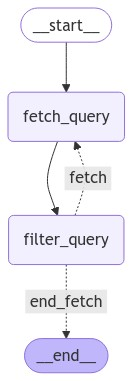

In [49]:
display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

## Test

In [50]:
document = """30일 학계에 따르면 아미트 아브라함 카타르 웨일코넬의대 교수 연구팀은 국제학술지 '영국의학회지(BMJ) 세계 보건' 최신호에 발표한 논평을 통해 "인간과 지구의 건강을 위해 생수의 사용을 재고해야 한다"는 주장을 제기했다."""
pprint(document)

("30일 학계에 따르면 아미트 아브라함 카타르 웨일코넬의대 교수 연구팀은 국제학술지 '영국의학회지(BMJ) 세계 보건' 최신호에 발표한 "
 '논평을 통해 "인간과 지구의 건강을 위해 생수의 사용을 재고해야 한다"는 주장을 제기했다.')


In [51]:
import uuid


def answer_by_agent(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = workflow.invoke(
        {
            "document": example["input"],
        },
        config
    )
    return {"response": state_dict["queries"]}


example = {
    "input": document
}
response = answer_by_agent(example)
response

{'response': ['아미트 아브라함 카타르 웨일코넬의대 교수 연구팀이 국제학술지에 발표한 논평에서 무엇에 대해 주장을 제기했나요?',
  '그 논문은 어떤 학술지에 실려 있나요?',
  "'영국의학회지(BMJ) 세계 보건' 최신호에 실린 논평에서 인간과 지구의 건강에 어떤 영향을 미치는지 설명해줘",
  '아미트 아브라함 카타르 웨일코넬의대 교수 연구팀은 생수 사용이 문제가 되는 이유를 무엇이라고 주장했나요?']}